In [60]:
# Helper functions
from notebooks.util.distribution_utils import *

from liquidity.util.utils import compute_returns, get_agg_features
from hurst_exponent.util.utils import augmented_dickey_fuller

In [61]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
# Number of events to use
EVENTS_RANGE = 1400000

# Window/bin size for computing imbalances
T = 500

## Load raw sample data

In [63]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Return magnitudes

In [5]:
# Return magnitude (volatility)
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

return_magnitudes = {
  'TSLA': abs(tsla_returns),
  'MSFT': abs(msft_returns),
  'AMZN': abs(amzn_returns),
  'NFLX': abs(nflx_returns),
  'EBAY': abs(ebay_returns),
  'APPL': abs(appl_returns)
}
# Update the dictionary to only keep the first EVENTS_RANGE items
return_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in return_magnitudes.items()}

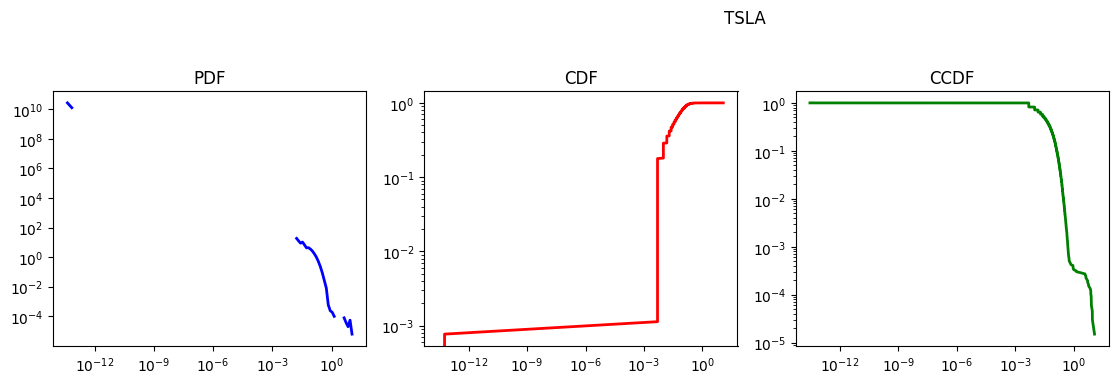

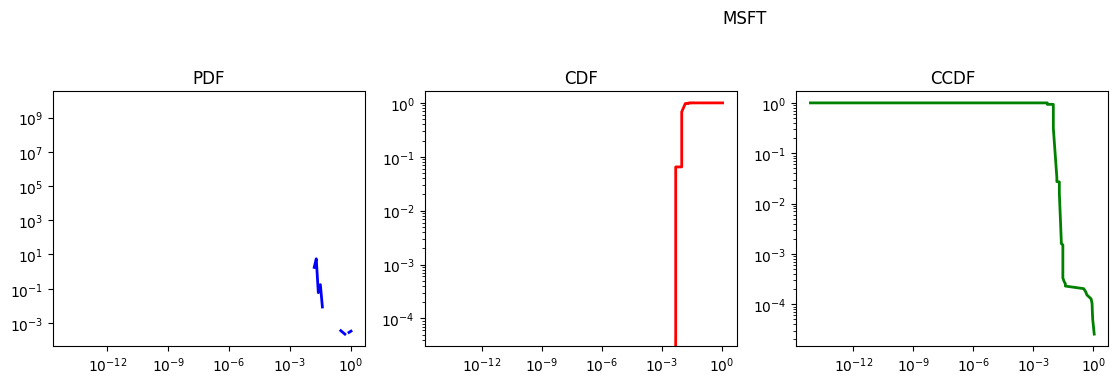

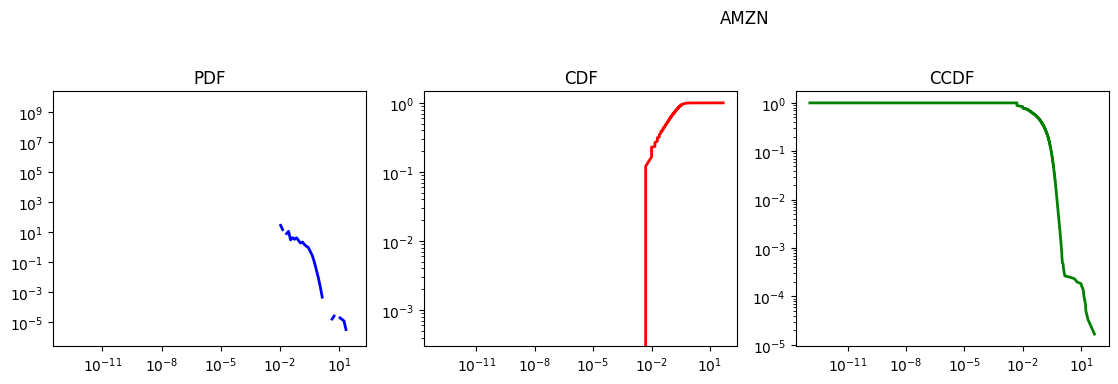

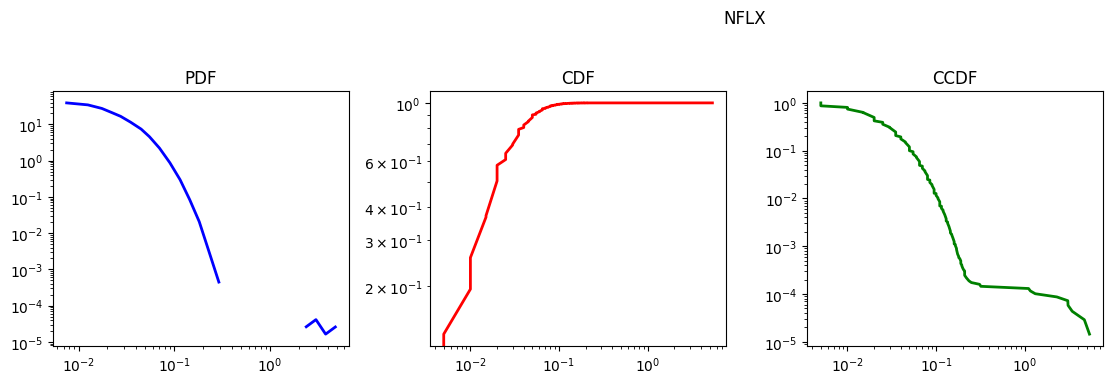

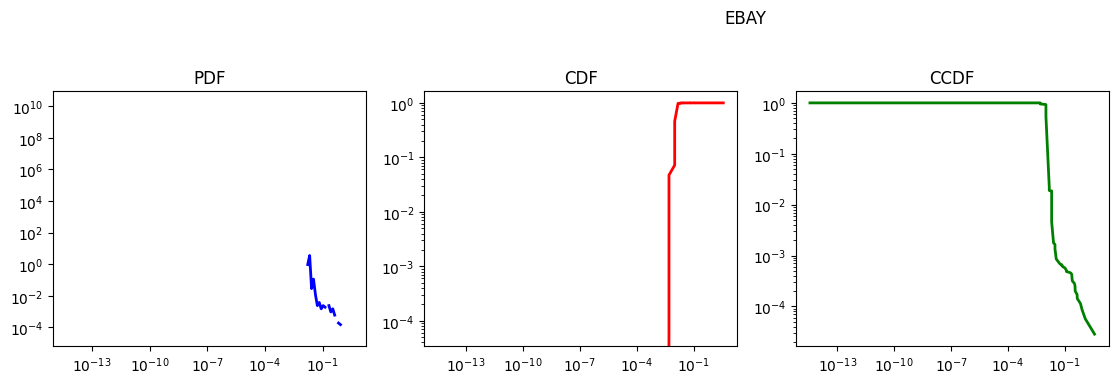

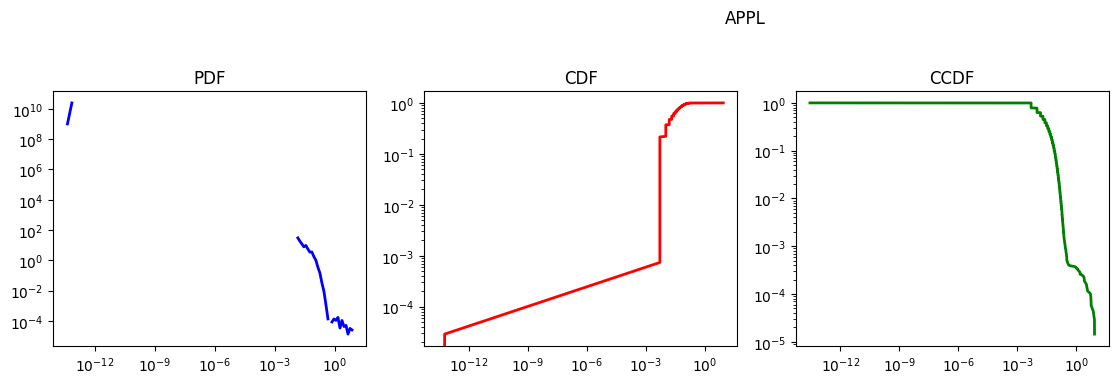

In [6]:
# Plot distribution of returns_magnitudes for each stock
for stock_name, data in return_magnitudes.items():
    plot_distributions(data, stock_name)

### Stationarity Test

In [ ]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data, stock)

#### 1.2. Fit power law distribution

In [7]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volatility_data = os.path.join(root_dir, 'data', 'generated', 'mo_volatility_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(volatility_data):
    volatility_fit_objects = fit_and_save(return_magnitudes, volatility_data)
else:
    volatility_fit_objects = load_fit_objects(volatility_data)

volatility_fit_objects

{'TSLA': <powerlaw.Fit at 0x32c556550>,
 'MSFT': <powerlaw.Fit at 0x32d689f90>,
 'AMZN': <powerlaw.Fit at 0x15427c5d0>,
 'NFLX': <powerlaw.Fit at 0x317f2f190>,
 'EBAY': <powerlaw.Fit at 0x1542c8f90>,
 'APPL': <powerlaw.Fit at 0x32d699110>}

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1507: RuntimeWarning: overflow encountered in divide
  likelihoods = f/C
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: divide by zero encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution give

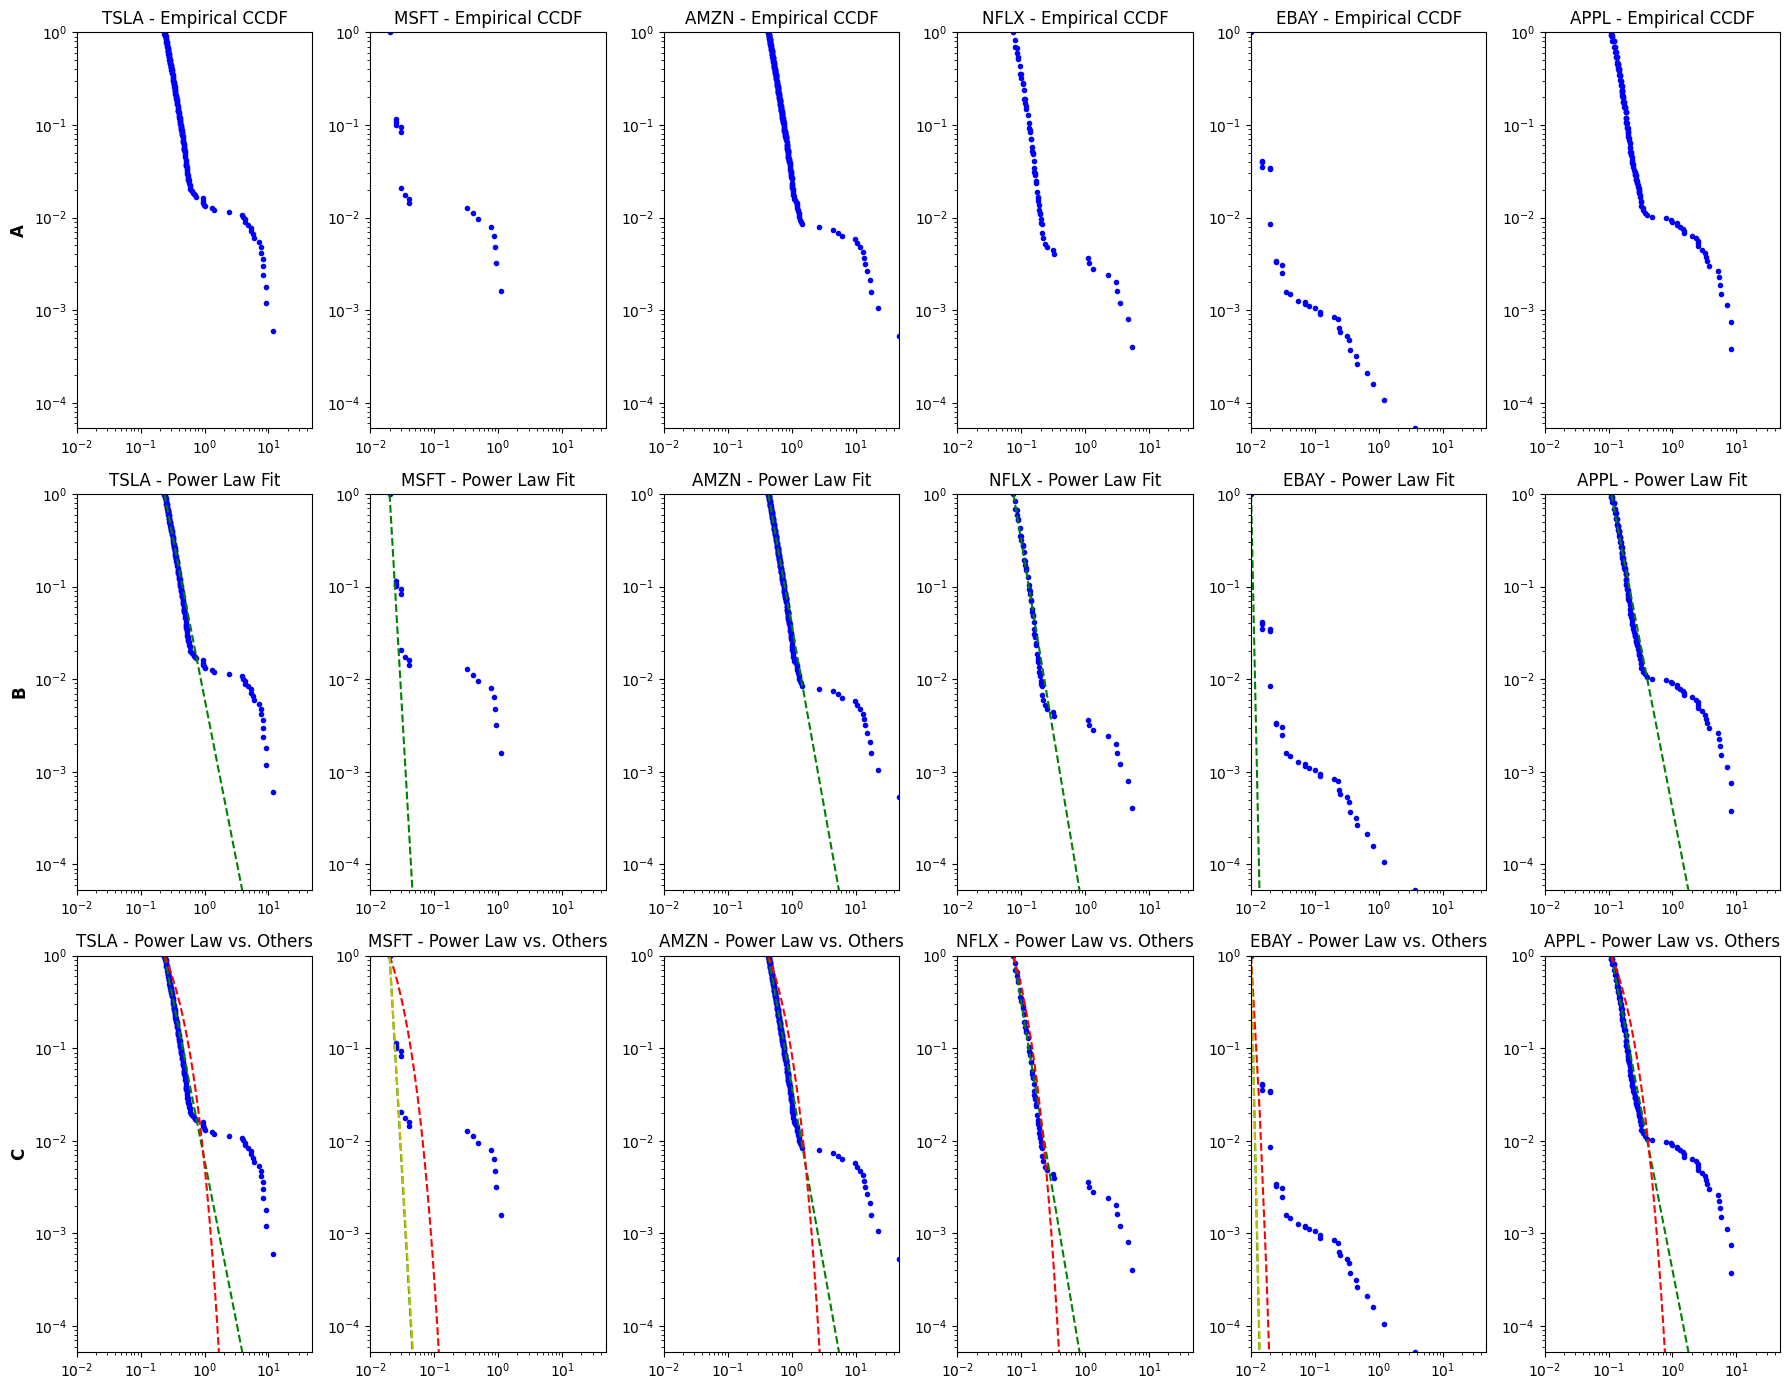

In [8]:
# Plot fitted objects
plot_fit_objects(volatility_fit_objects)

#### 1.3. Retrieve Power law fitting results

In [9]:
# Get fitting parameters for specific distribution across all stocks
volatility_fit_results = get_fitting_params(volatility_fit_objects, 'power_law')
print(volatility_fit_results)

  Stock Distribution      alpha   xmin  KS Distance
0  TSLA    power_law   4.510995  0.235     0.041463
1  MSFT    power_law  12.965971  0.020     0.086284
2  AMZN    power_law   4.870173  0.430     0.029750
3  NFLX    power_law   5.135622  0.075     0.076225
4  EBAY    power_law  33.561789  0.010     0.041177
5  APPL    power_law   4.540179  0.110     0.073990


In [10]:
# Average Alpha exponents across stocks
min_alpha = volatility_fit_results['alpha'].min()
max_alpha = volatility_fit_results['alpha'].max()
avg_alpha = volatility_fit_results['alpha'].mean()
std_dev_alpha = volatility_fit_results['alpha'].std()

print(f"Min Alphaa: {min_alpha}")
print(f"Max Alphaa: {max_alpha}")
print(f"Average Alphaa: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alphaa: 4.510994601909607
Max Alphaa: 33.56178914411045
Average Alphaa: 10.93078824538099
std_dev_alpha: 11.564366070397217


#### 1.4. Compare alternative distributions

In [ ]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volatility_comparison = distribution_compare(volatility_fit_objects, 'exponential')
display(volatility_comparison)

## 2. Orderflow

### 2.3. Signed Volume

In [18]:
# Signed Volume
signed_volume = {
  'TSLA': tsla_raw_df['norm_trade_volume'] * tsla_raw_df['trade_sign'],
  'MSFT': msft_raw_df['norm_trade_volume'] * msft_raw_df['trade_sign'],
  'AMZN': amzn_raw_df['norm_trade_volume'] * amzn_raw_df['trade_sign'],
  'NFLX': nflx_raw_df['norm_trade_volume'] * nflx_raw_df['trade_sign'],
  'EBAY': ebay_raw_df['norm_trade_volume'] * ebay_raw_df['trade_sign'],
  'APPL': appl_raw_df['norm_trade_volume'] * appl_raw_df['trade_sign']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
signed_volume = {stock: data.head(EVENTS_RANGE) for stock, data in signed_volume.items()}

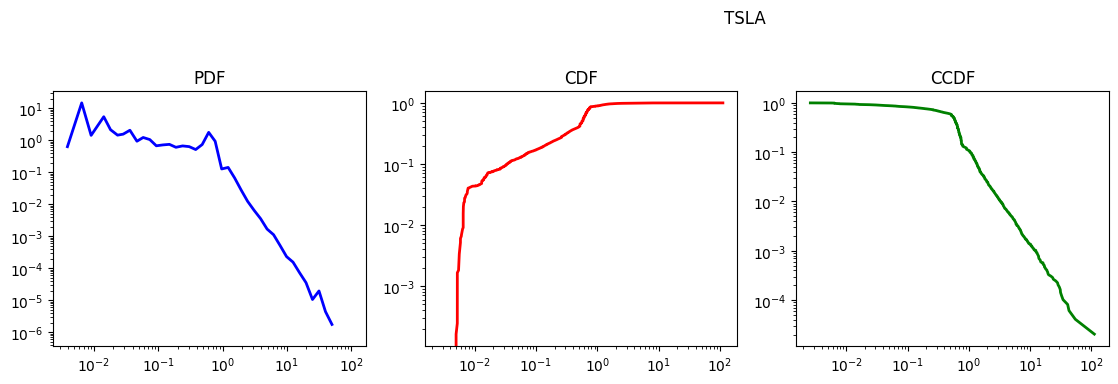

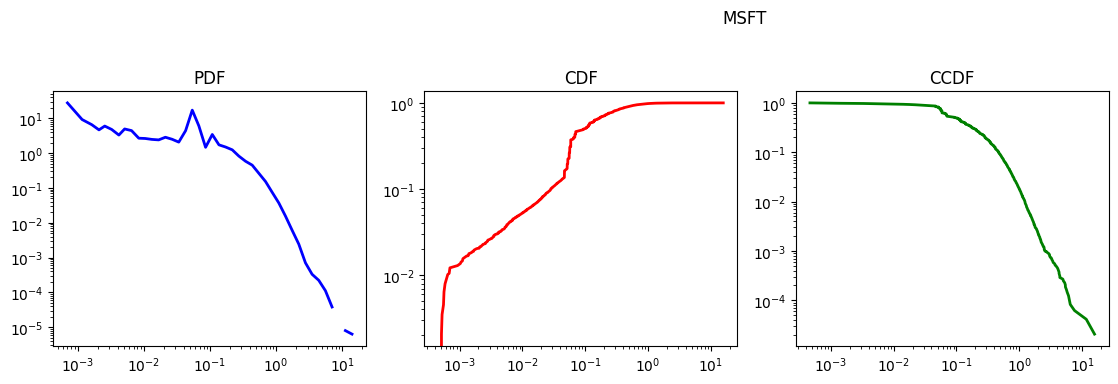

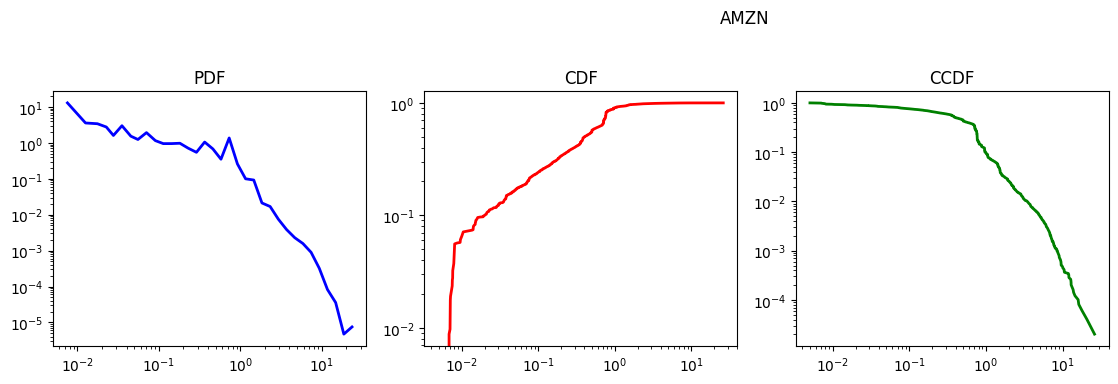

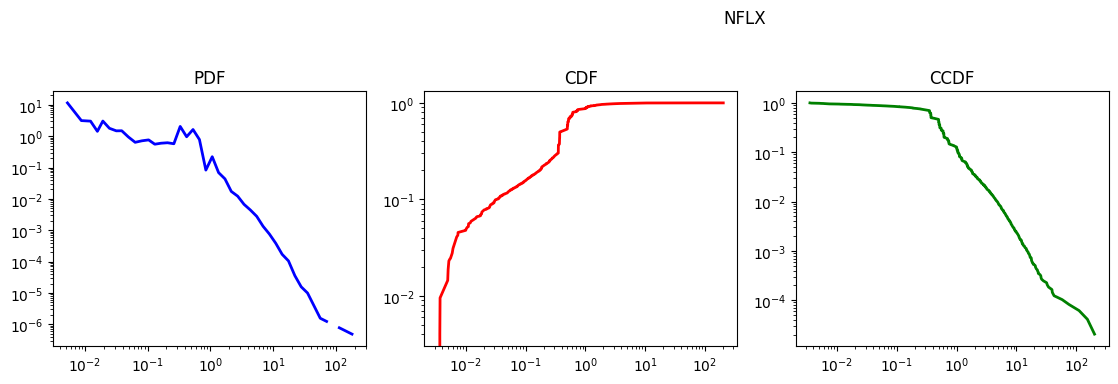

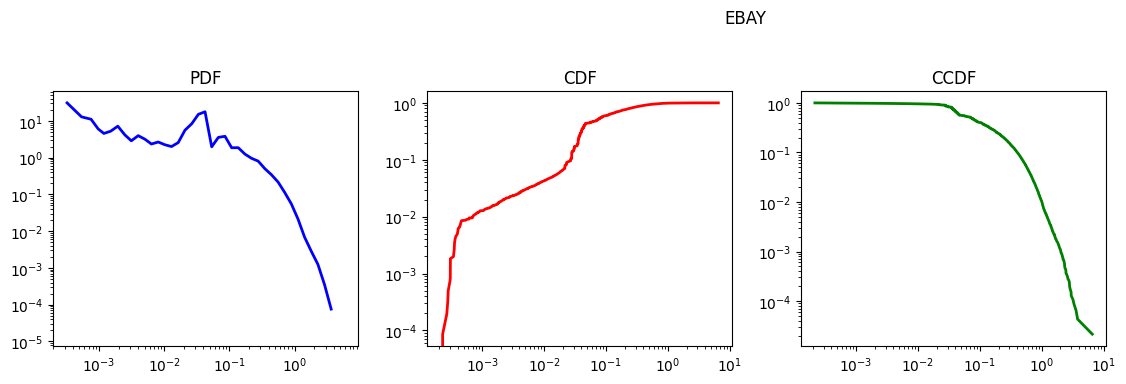

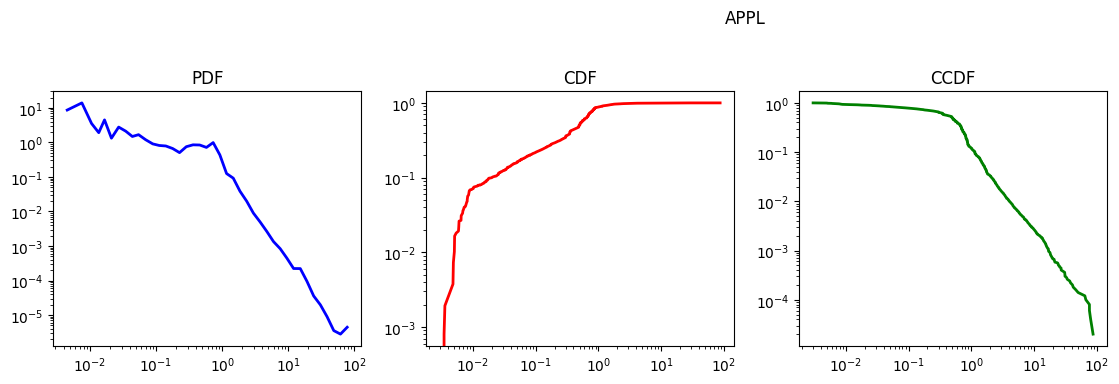

In [19]:
# Plot distribution of signed_volume for each stock
for stock_name, data in signed_volume.items():
    plot_distributions(data, stock_name)

#### Stationarity Test

In [ ]:
# ADF test
for stock, data in signed_volume.items():
    augmented_dickey_fuller(data, stock)

#### 2.2. Fit power law distribution

In [13]:
# 1. Fit Powerlaw and retrieve fitted object/ results
signed_volume_data = os.path.join(root_dir, 'data', 'generated', 'mo_signed_volume_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(signed_volume_data):
    volume_fit_objects = fit_and_save(signed_volume, signed_volume_data)
else:
    volume_fit_objects = load_fit_objects(signed_volume_data)

volume_fit_objects

Calculating best minimal value for power law fit


/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1151: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))


KeyboardInterrupt: 

In [ ]:
# Plot fitted objects
plot_fit_objects(volume_fit_objects)

#### 2.3. Retrieve Power law fitting results

In [ ]:
# Get fitting parameters for specific distribution across all stocks
volume_fit_results = get_fitting_params(volume_fit_objects, 'power_law')
print(volume_fit_results)

In [ ]:
# Average Alpha exponents across stocks
min_alpha = volume_fit_results['alpha'].min()
max_alpha = volume_fit_results['alpha'].max()
avg_alpha = volume_fit_results['alpha'].mean()
std_dev_alpha = volume_fit_results['alpha'].std()

print(f"Min Alphaa: {min_alpha}")
print(f"Max Alphaa: {max_alpha}")
print(f"Average Alphaa: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

#### 1.4. Compare alternative distributions

In [ ]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_comparison = distribution_compare(volatility_fit_objects, 'exponential')
display(volume_comparison)

## 3. Signed Ordeflow Imbalance

In [64]:
# Aggregate orderflow
tsla_imbalance = get_agg_features(tsla_raw_df, [T])
msft_imbalance = get_agg_features(msft_raw_df, [T])
amzn_imbalance= get_agg_features(amzn_raw_df, [T])
nflx_imbalance = get_agg_features(nflx_raw_df, [T])
ebay_imbalance = get_agg_features(ebay_raw_df, [T])
appl_imbalance = get_agg_features(appl_raw_df, [T])

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_imbalance['sign_imbalance'],
  'MSFT': msft_imbalance['sign_imbalance'],
  'AMZN': amzn_imbalance['sign_imbalance'],
  'NFLX': nflx_imbalance['sign_imbalance'],
  'EBAY': ebay_imbalance['sign_imbalance'],
  'APPL': appl_imbalance['sign_imbalance']
}

# Sign Volume Imbalance
volume_imbalance = {
  'TSLA': tsla_imbalance['vol_imbalance'],
  'MSFT': msft_imbalance['vol_imbalance'],
  'AMZN': amzn_imbalance['vol_imbalance'],
  'NFLX': nflx_imbalance['vol_imbalance'],
  'EBAY': ebay_imbalance['vol_imbalance'],
  'APPL': appl_imbalance['vol_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in sign_imbalance.items()}
# volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in volume_imbalance.items()}

### Stationarity Test

In [ ]:
# sign_imbalance ADF test
print('Order-sign Imbalance')
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data, stock)
print('\n')

# volume_imbalance ADF test
print('Order-sign Imbalance')
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data, stock)

### 3.2. Order Sign Imbalance

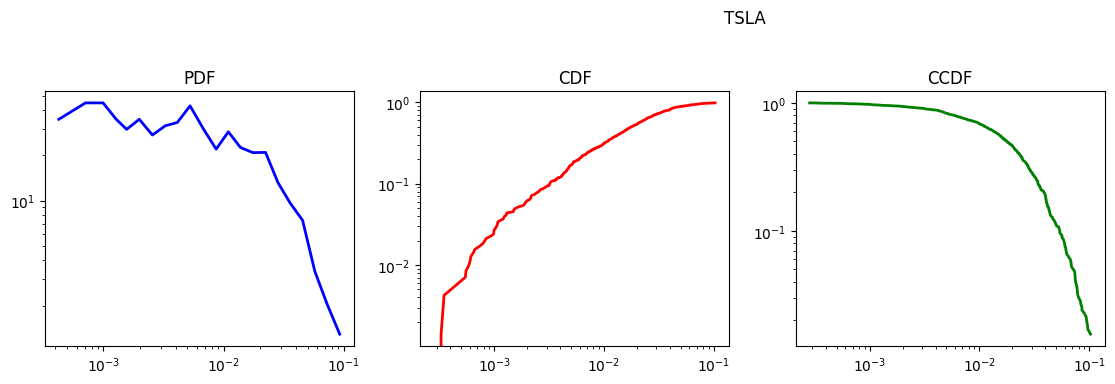

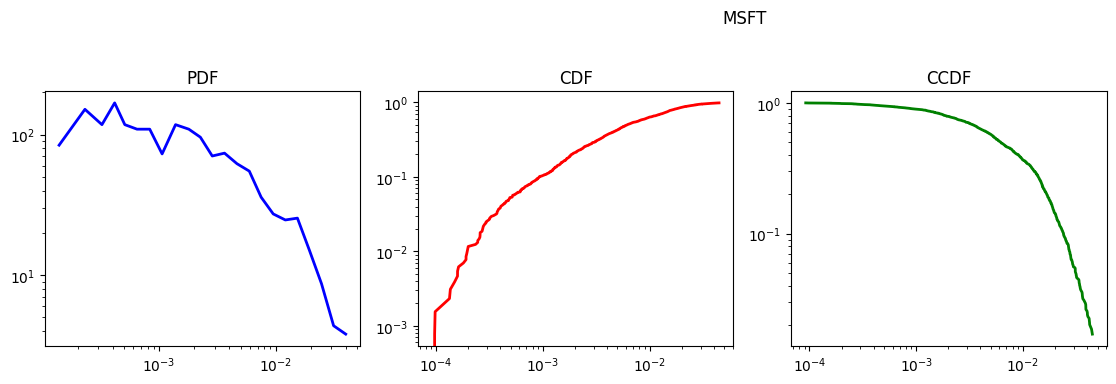

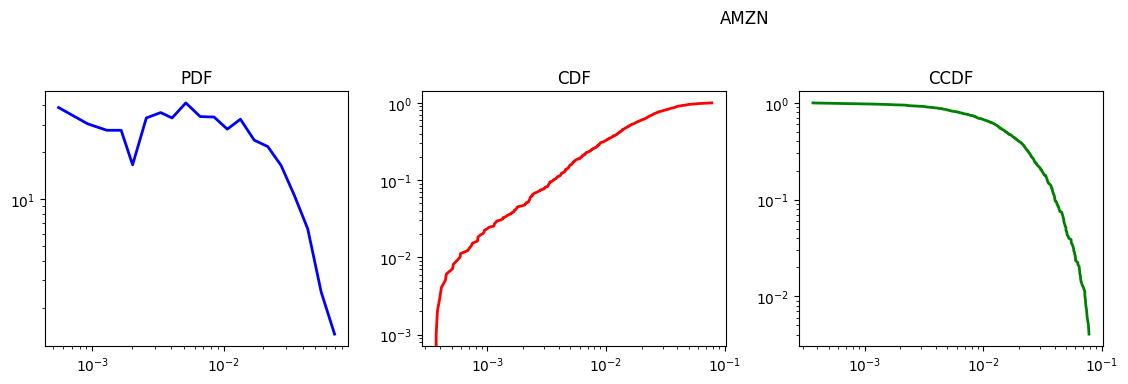

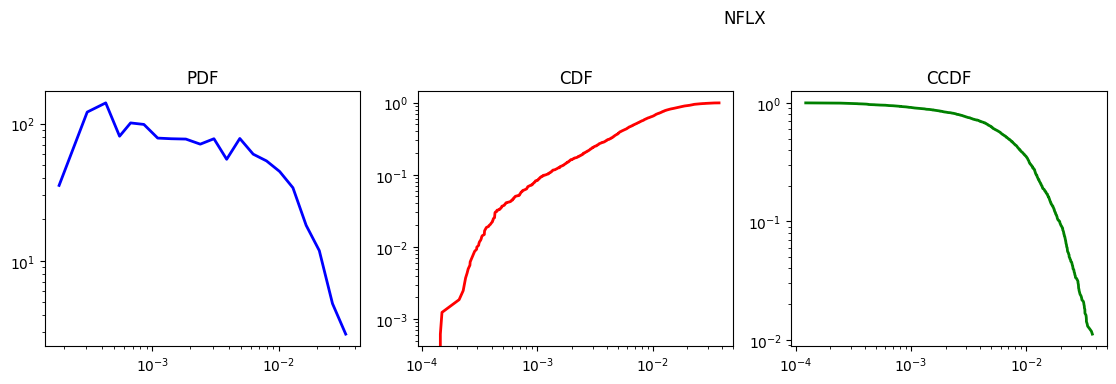

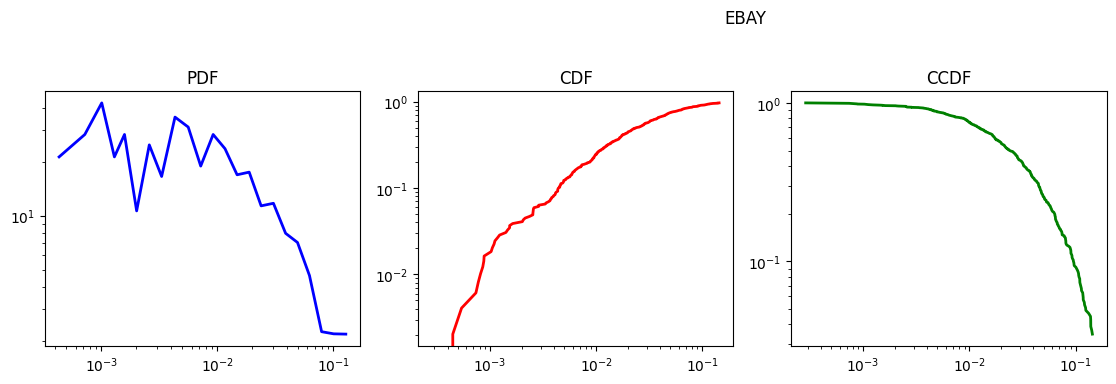

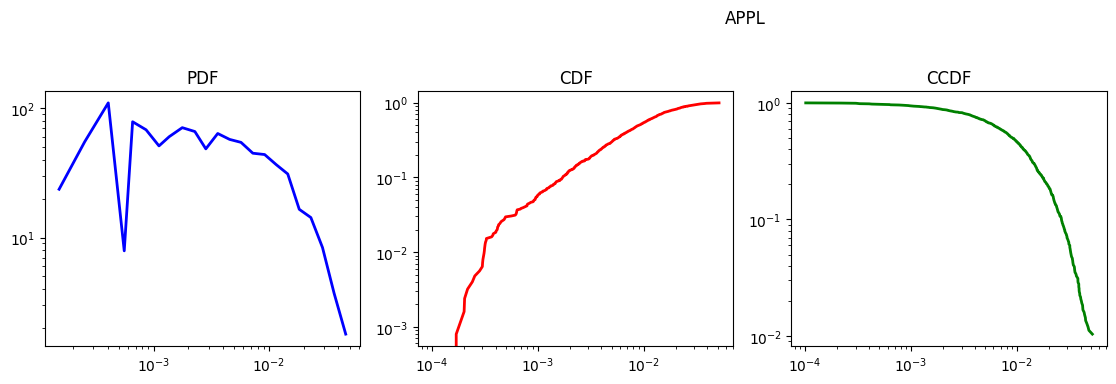

In [65]:
# Plot distribution of sign_imbalance for each stock
for stock_name, data in sign_imbalance.items():
    plot_distributions(data, stock_name)

#### 3.2.1. Fit power law distribution

In [66]:
# 1. Fit Powerlaw and retrieve fitted object/ results
sign_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'mo_sign_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(sign_imbalance_data):
    sign_imbalance_fit_objects = fit_and_save(sign_imbalance, sign_imbalance_data)
else:
    sign_imbalance_fit_objects = load_fit_objects(sign_imbalance_data)

sign_imbalance_fit_objects

{'TSLA': <powerlaw.Fit at 0x373008f50>,
 'MSFT': <powerlaw.Fit at 0x2fe571d50>,
 'AMZN': <powerlaw.Fit at 0x2ba534fd0>,
 'NFLX': <powerlaw.Fit at 0x384874e10>,
 'EBAY': <powerlaw.Fit at 0x3146d4c90>,
 'APPL': <powerlaw.Fit at 0x356eff750>}

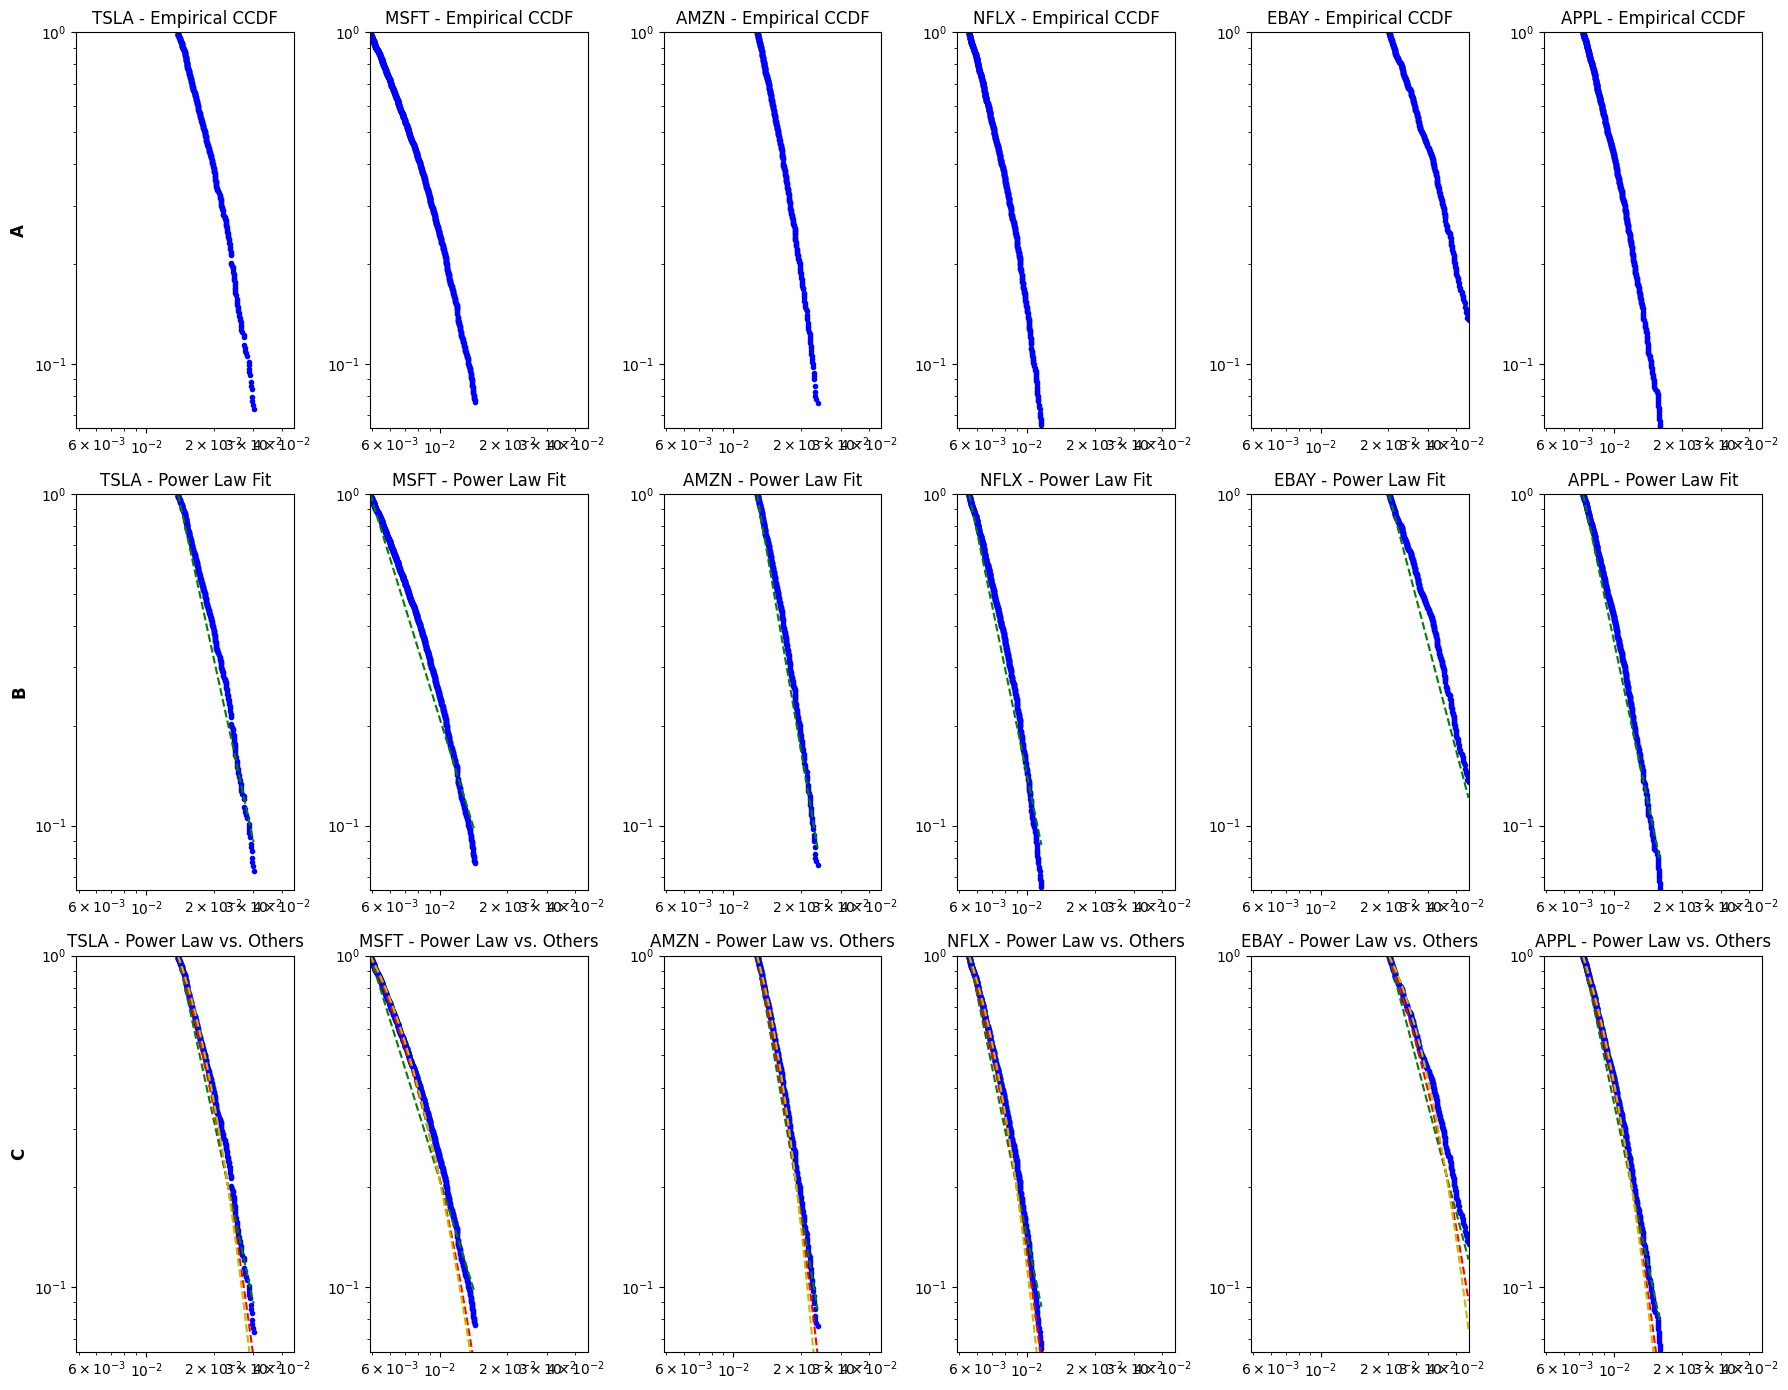

In [67]:
# Plot fitted objects
plot_fit_objects(sign_imbalance_fit_objects)

#### 3.2.2 Retrieve Power law fitting results

In [68]:
# Get fitting parameters for specific distribution across all stocks
sign_imbalance_fit_results = get_fitting_params(sign_imbalance_fit_objects, 'power_law')
print(sign_imbalance_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  4.122653  0.013855     0.074347
1  MSFT    power_law  3.182467  0.004892     0.084121
2  AMZN    power_law  4.959025  0.012739     0.076822
3  NFLX    power_law  4.291035  0.005528     0.078631
4  EBAY    power_law  3.586325  0.020145     0.103226
5  APPL    power_law  4.218624  0.007267     0.067342


In [69]:
# Average Alpha exponents across stocks
min_alpha = sign_imbalance_fit_results['alpha'].min()
max_alpha = sign_imbalance_fit_results['alpha'].max()
avg_alpha = sign_imbalance_fit_results['alpha'].mean()
std_dev_alpha = sign_imbalance_fit_results['alpha'].std()

print(f"Min Alphaa: {min_alpha}")
print(f"Max Alphaa: {max_alpha}")
print(f"Average Alphaa: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alphaa: 3.1824672561347027
Max Alphaa: 4.95902544594654
Average Alphaa: 4.060021668339288
std_dev_alpha: 0.6140264509278378


#### 3.2.3 Compare alternative distributions

In [70]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
sign_imbalance_comparison = distribution_compare(sign_imbalance_fit_objects, 'exponential')
display(sign_imbalance_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,172.809191,0.013855,4.122653,0.074347,0.049858,-7.448659,9.429358e-14
1,MSFT,exponential,303.982158,0.004892,3.182467,0.084121,0.034985,-13.159243,1.505869e-39
2,AMZN,exponential,252.550787,0.012739,4.959025,0.076822,0.044716,-8.282919,1.201917e-16
3,NFLX,exponential,463.420330,0.005528,4.291035,0.078631,0.044024,-11.338375,8.470260e-30
4,EBAY,exponential,94.302399,0.020145,3.586325,0.103226,0.073287,-9.041197,1.549660e-19
5,APPL,exponential,340.439656,0.007267,4.218624,0.067342,0.034320,-9.430766,4.071051e-21


### 3.3. Volume Imbalance

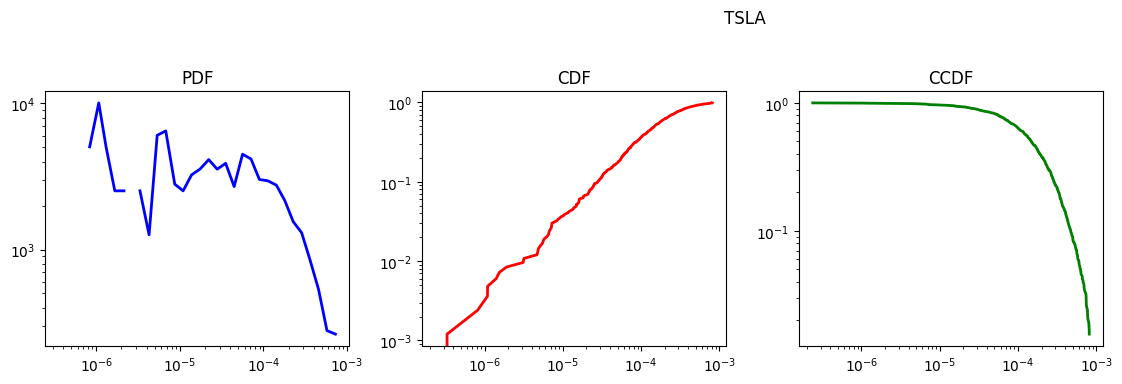

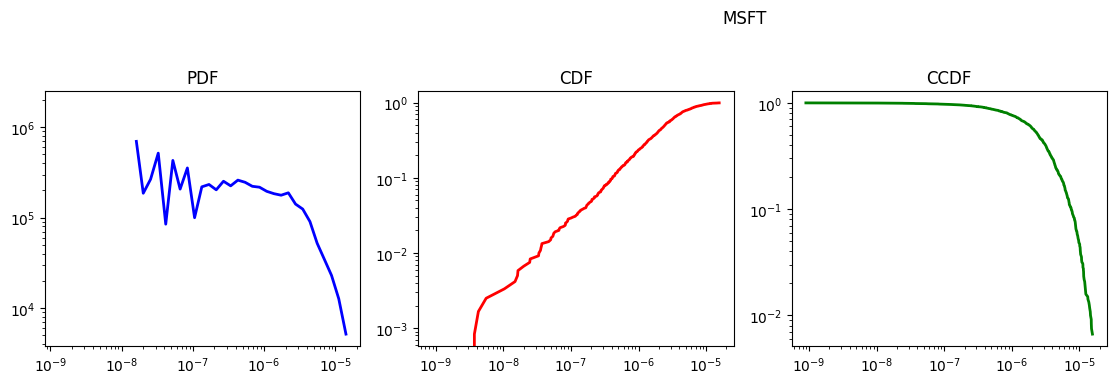

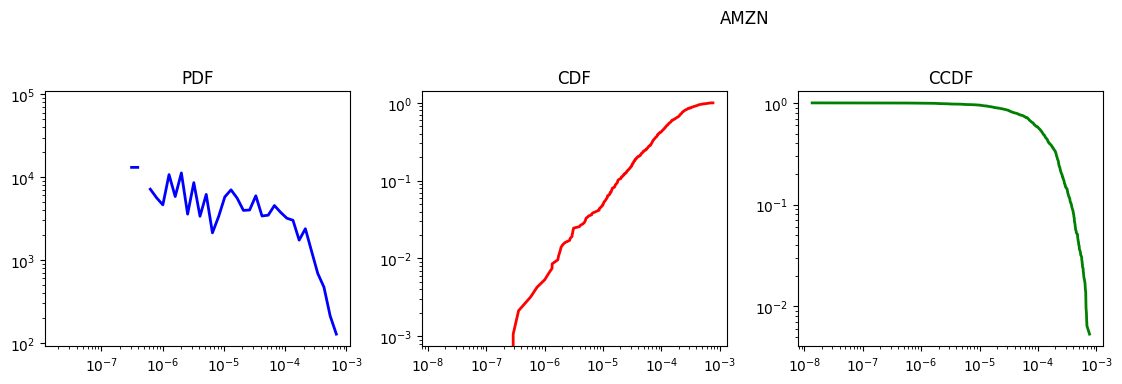

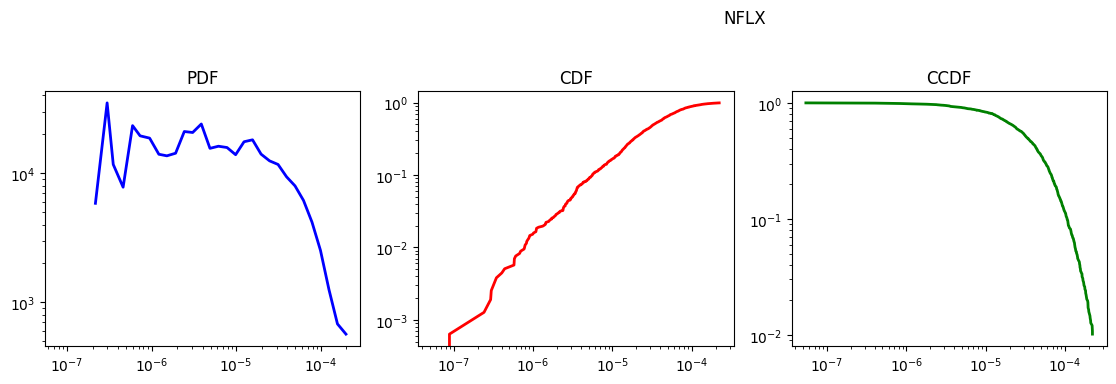

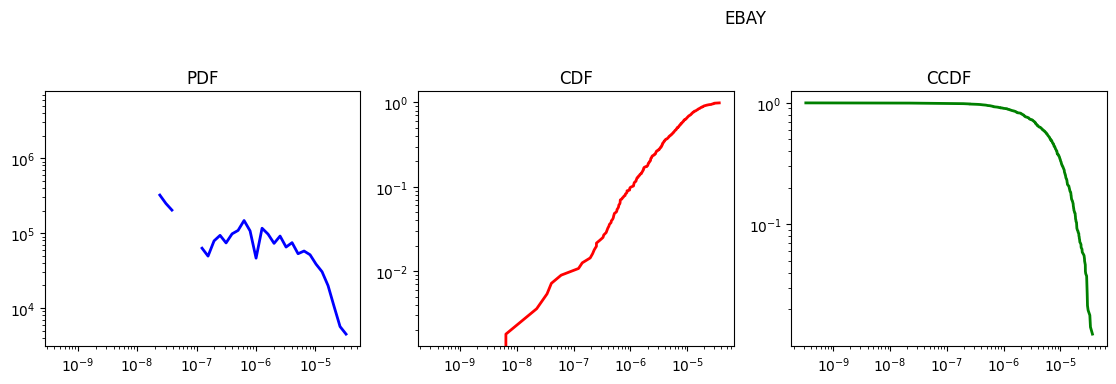

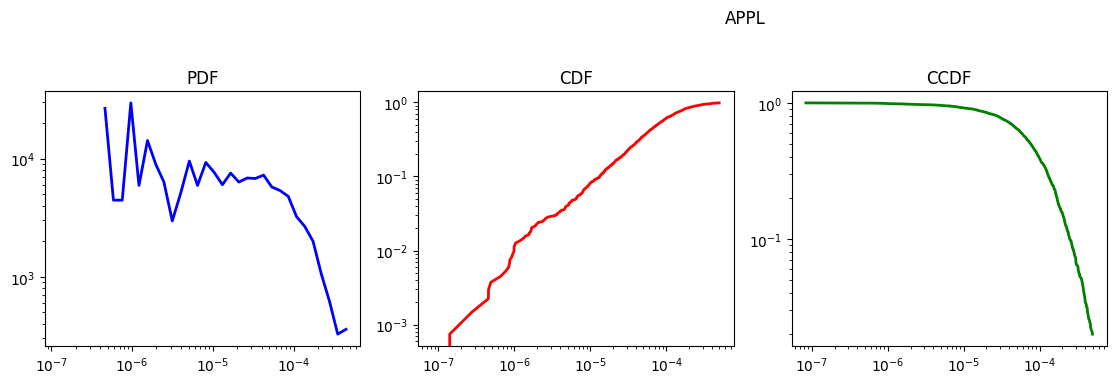

In [71]:
# Plot distribution of volume_imbalance for each stock
for stock_name, data in volume_imbalance.items():
    plot_distributions(data, stock_name)

#### 3.3.2 Fit power law distribution

In [72]:
# 1. Fit Powerlaw and retrieve fitted object/ results
volume_imbalance_data = os.path.join(root_dir, 'data', 'generated', 'mo_volume_imbalance_distributions.pkl')

# If the file doesn't exist, fit the series and save the results.
if not os.path.exists(volume_imbalance_data):
    volume_imbalance_data_fit_objects = fit_and_save(volume_imbalance, volume_imbalance_data)
else:
    volume_imbalance_data_fit_objects = load_fit_objects(volume_imbalance_data)

volume_imbalance_data_fit_objects

Calculating best minimal value for power law fit


/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1151: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data/self.xmin)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/powerlaw.py:1170: RuntimeWarning: invalid value encountered in log
  return 1 + len(data)/sum(log(data / (self.xmin)))


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


{'TSLA': <powerlaw.Fit at 0x2ffd28ad0>,
 'MSFT': <powerlaw.Fit at 0x37d122c10>,
 'AMZN': <powerlaw.Fit at 0x3145b8e90>,
 'NFLX': <powerlaw.Fit at 0x328986890>,
 'EBAY': <powerlaw.Fit at 0x2fe632dd0>,
 'APPL': <powerlaw.Fit at 0x379fb46d0>}

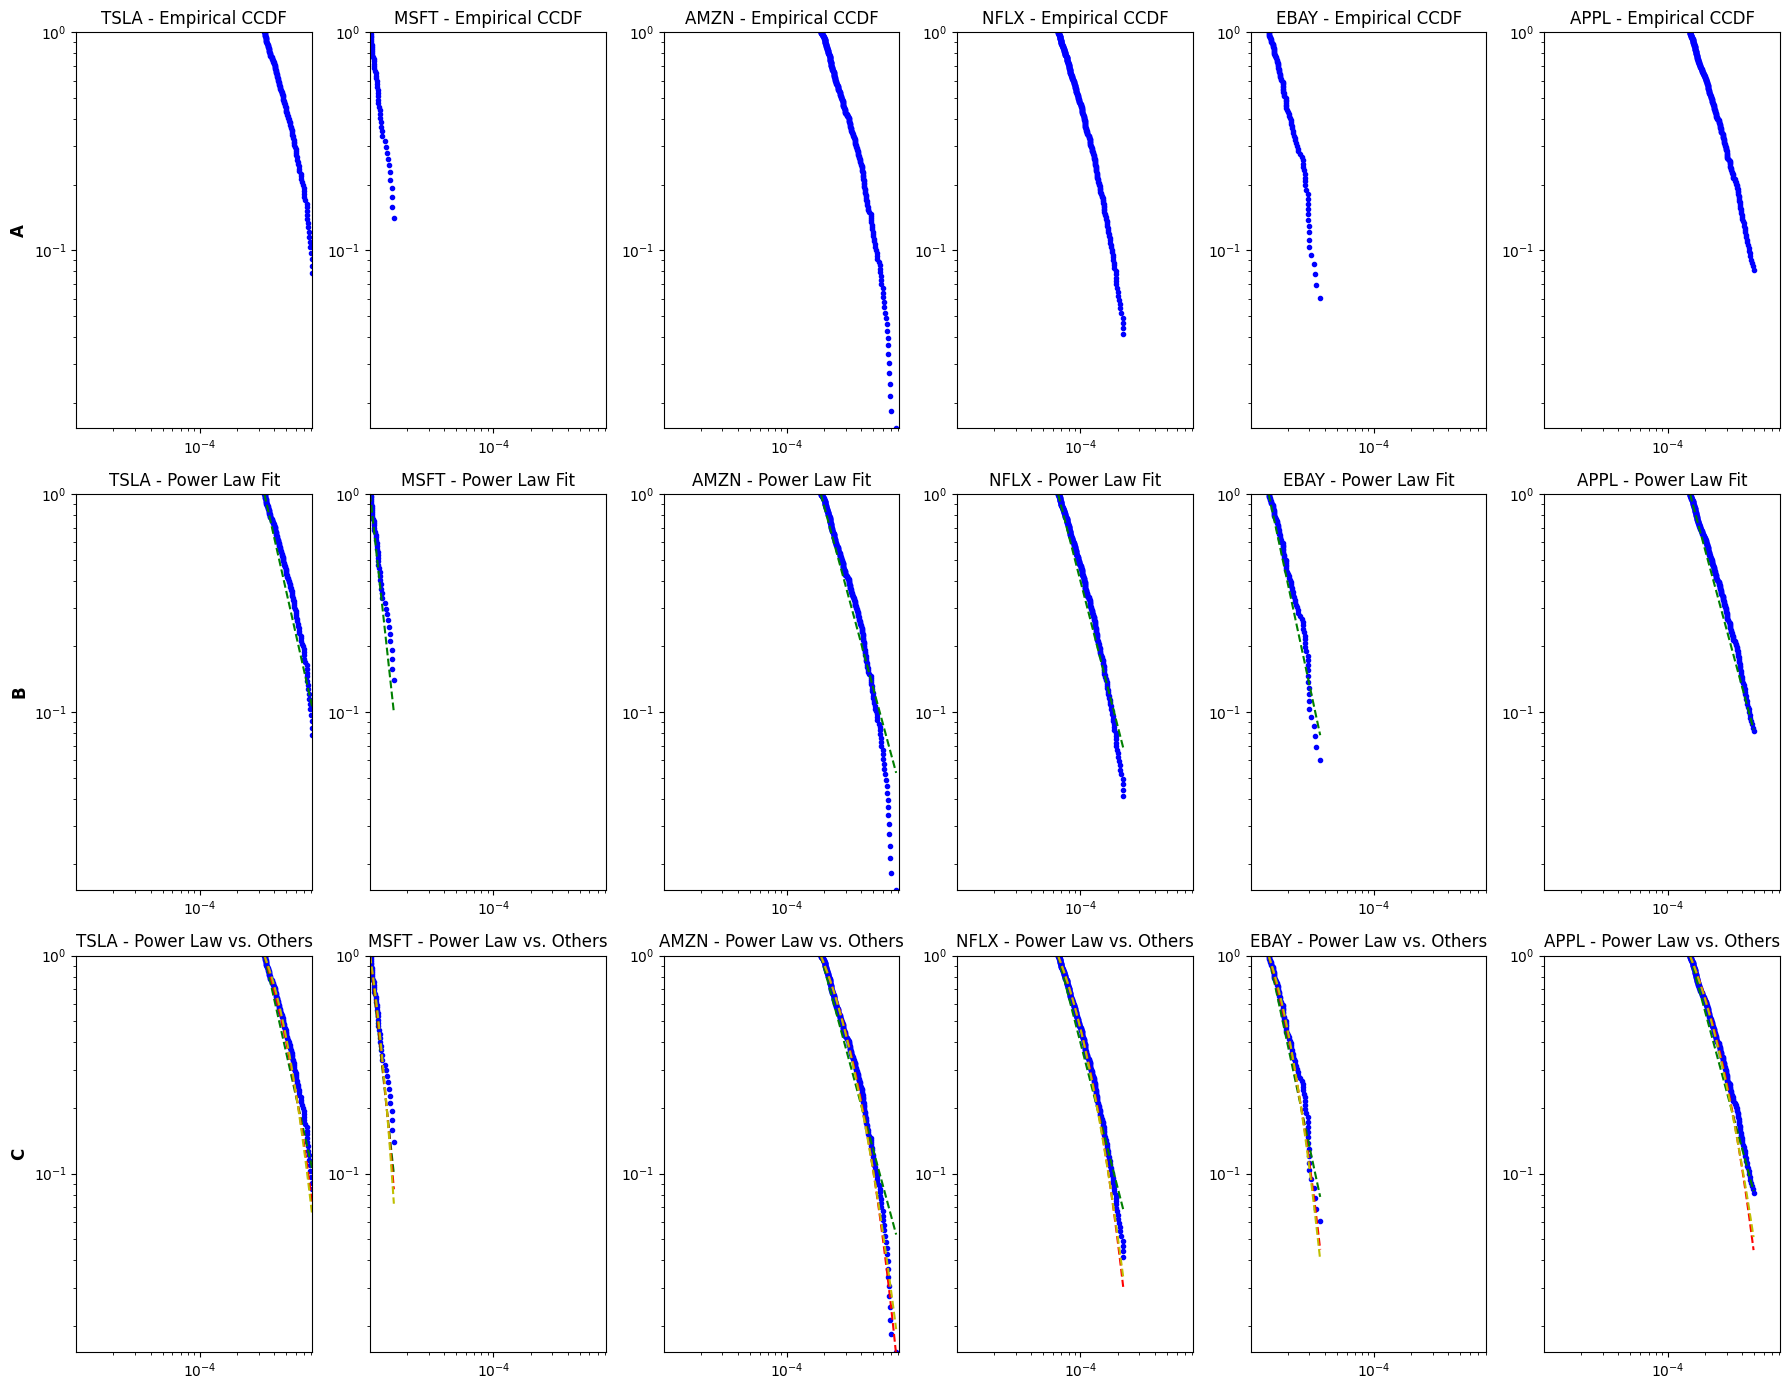

In [73]:
# Plot fitted objects
plot_fit_objects(volume_imbalance_data_fit_objects)

#### 3.3.2 Retrieve Power law fitting results

In [74]:
# Get fitting parameters for specific distribution across all stocks
volume_imbalance_fit_results = get_fitting_params(volume_imbalance_data_fit_objects, 'power_law')
print(volume_imbalance_fit_results)

  Stock Distribution     alpha      xmin  KS Distance
0  TSLA    power_law  3.525627  0.000334     0.090522
1  MSFT    power_law  6.191534  0.000010     0.093040
2  AMZN    power_law  3.097247  0.000188     0.071391
3  NFLX    power_law  3.207775  0.000066     0.072646
4  EBAY    power_law  3.652232  0.000014     0.092117
5  APPL    power_law  3.099660  0.000152     0.071218


In [75]:
# Average Alpha exponents across stocks
min_alpha = volume_imbalance_fit_results['alpha'].min()
max_alpha = volume_imbalance_fit_results['alpha'].max()
avg_alpha = volume_imbalance_fit_results['alpha'].mean()
std_dev_alpha = volume_imbalance_fit_results['alpha'].std()

print(f"Min Alphaa: {min_alpha}")
print(f"Max Alphaa: {max_alpha}")
print(f"Average Alphaa: {avg_alpha}")
print(f"std_dev_alpha: {std_dev_alpha}")

Min Alphaa: 3.0972468693357422
Max Alphaa: 6.191534309694457
Average Alphaa: 3.7956791535969803
std_dev_alpha: 1.1959522374107683


#### 3.3.3 Compare alternative distributions

In [76]:
# Compare against alternative heavy-tailed distributions
from IPython.display import display
volume_imbalance_comparison = distribution_compare(volume_imbalance_data_fit_objects, 'exponential')
display(volume_imbalance_comparison)

,Stock,Alternative Distribution,Lambda,xmin,Power Law Alpha,KS Distance (Power Law),KS Distance (exponential),Loglikelihood Ratio,p-value
0,TSLA,exponential,5448.946415,0.000334,3.525627,0.090522,0.064253,-4.321985,0.000015
1,MSFT,exponential,439484.691344,0.000010,6.191534,0.093040,0.093380,-2.190030,0.028522
2,AMZN,exponential,7287.878938,0.000188,3.097247,0.071391,0.049956,-3.854396,0.000116
3,NFLX,exponential,22450.745023,0.000066,3.207775,0.072646,0.035221,-4.440262,0.000009
4,EBAY,exponential,137277.413518,0.000014,3.652232,0.092117,0.075561,-3.197036,0.001388
5,APPL,exponential,9027.213344,0.000152,3.099660,0.071218,0.063037,-3.582588,0.000340
